In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import os

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, timesteps=1000):
        super().__init__()

        self.num_timesteps = timesteps

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28)
        )
        self.pool = nn.MaxPool2d(2)

        self.enc1 = conv_block(2, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, output_padding=1)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        t_embed = self.time_embed(t.float().view(-1, 1) / 1000.0).view(-1, 1, 28, 28)
        x = torch.cat([x, t_embed], dim=1)

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)


In [ ]:
model = UNet(in_channels=2, out_channels=1, timesteps=1000)
x = torch.randn(1, 1, 28, 28)
y = model(x, torch.tensor([2]))
print(y.shape)  # should print: torch.Size([1, 1, 28, 28])

torch.Size([1, 1, 28, 28])


In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.999)

In [ ]:
class DDPM:
    def __init__(self, model, timesteps=1000):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.timesteps = timesteps
        self.betas = cosine_beta_schedule(timesteps).to(self.device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

        # Precompute constants
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat).to(self.device)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat).to(self.device)

    def add_noise(self, x0, t, noise):
        return (
            self.sqrt_alpha_hat[t][:, None, None, None] * x0 +
            self.sqrt_one_minus_alpha_hat[t][:, None, None, None] * noise
        )

    def train(self, dataloader, optimizer, epochs=10, use_ema=True):
        ema_model = UNet().to(self.device)
        ema_model.load_state_dict(self.model.state_dict())

        def update_ema(ema, model, decay=0.9999):
            for ema_param, param in zip(ema.parameters(), model.parameters()):
                ema_param.data.mul_(decay).add_(param.data, alpha=1 - decay)

        self.model.train()
        for epoch in range(epochs):
            loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
            for x, _ in loop:
                x = x.to(self.device)
                t = torch.randint(0, self.timesteps, (x.size(0),), device=self.device)
                noise = torch.randn_like(x)
                x_noisy = self.add_noise(x, t, noise)

                predicted = self.model(x_noisy, t)
                loss = F.mse_loss(predicted, noise)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if use_ema:
                    update_ema(ema_model, self.model)

                loop.set_postfix(loss=loss.item())

        if use_ema:
            self.model.load_state_dict(ema_model.state_dict())

    @torch.no_grad()
    def sample(self, shape, steps=None):
        steps = steps or self.timesteps
        x = torch.randn(shape).to(self.device)
        for t in reversed(range(steps)):
            t_batch = torch.full((shape[0],), t, device=self.device, dtype=torch.long)
            beta = self.betas[t]
            alpha = self.alphas[t]
            alpha_hat = self.alpha_hat[t]

            pred_noise = self.model(x, torch.tensor([t]).to(self.device))
            x = (1 / alpha.sqrt()) * (x - (1 - alpha) / (1 - alpha_hat).sqrt() * pred_noise)
            if t > 0:
                noise = torch.randn_like(x)
                x += beta.sqrt() * noise

        return torch.clamp((x + 1) / 2, 0, 1)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # [-1, 1]
])
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.06MB/s]


In [ ]:
model = UNet()
ddpm = DDPM(model, timesteps=1000)
optimizer = torch.optim.Adam(ddpm.model.parameters(), lr=1e-3)

In [ ]:
ddpm.train(dataloader, optimizer, epochs=10)
torch.save(ddpm.model.state_dict(), "unet.pth")

Epoch 6:  27%|██▋       | 16/59 [00:11<00:31,  1.37it/s, loss=0.155]


KeyboardInterrupt: 

In [ ]:
torch.save(ddpm.model.state_dict(), "unet.pth")

In [ ]:
model_load = UNet()
model_load.load_state_dict(torch.load("/content/drive/MyDrive/Colabs/unet.pth"))
model_load.eval()

UNet(
  (time_embed): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [ ]:
ddpm_eval = DDPM(model_load, timesteps=1000)

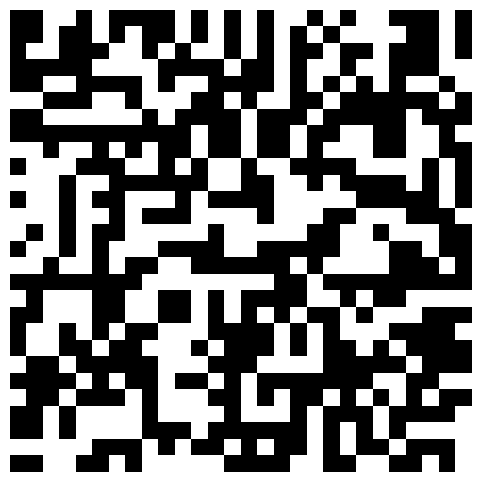

In [ ]:
samples = ddpm.sample((1, 1, 28, 28))
grid = utils.make_grid(samples, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Dataset Loader from CSV
# -------------------------
class MNISTFromCSV(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path, header=None)
        print(df.iloc[1:, 0].values)
        self.labels = torch.tensor(df.iloc[1:, 0].values)
        self.images = torch.tensor(df.iloc[1:, 1:].values.astype("float32") / 255.0)
        self.images = self.images.view(-1, 1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# -------------------------
# Simple U-Net
# -------------------------
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28)
        )

        self.enc1 = conv_block(2, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        t_embed = self.time_embed(t.float().view(-1, 1) / 1000.0).view(-1, 1, 28, 28)
        x = torch.cat([x, t_embed], dim=1)

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))

        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)

# -------------------------
# DDPM Logic
# -------------------------
class DDPM:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.betas = torch.linspace(1e-4, 0.02, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        alpha_hat = self.alpha_hats[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_hat) * x0 + torch.sqrt(1 - alpha_hat) * noise, noise

    def sample(self, model, n_samples=1, device='cpu'):
        x = torch.randn(n_samples, 1, 28, 28).to(device)
        for t in reversed(range(self.timesteps)):
            time_tensor = torch.full((n_samples,), t, dtype=torch.long, device=device)
            with torch.no_grad():
                eps_theta = model(x, time_tensor)
            beta = self.betas[t]
            alpha = self.alphas[t]
            alpha_hat = self.alpha_hats[t]
            noise = torch.randn_like(x) if t > 0 else 0
            x = (1 / torch.sqrt(alpha)) * (x - beta / torch.sqrt(1 - alpha_hat) * eps_theta) + torch.sqrt(beta) * noise
        return x

# -------------------------
# Image Saving
# -------------------------
def save_grid(samples, filename):
    samples = samples.cpu().squeeze(1)
    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axs.flat):
        ax.imshow(samples[i], cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# -------------------------
# Training Loop
# -------------------------
def train(csv_path, epochs=50, batch_size=128, sample_every=10, device='cpu'):
    dataset = MNISTFromCSV(csv_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    ddpm = DDPM()

    os.makedirs("samples", exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        for x0, _ in dataloader:
            x0 = x0.to(device)
            t = torch.randint(0, ddpm.timesteps, (x0.size(0),), device=device)
            xt, noise = ddpm.add_noise(x0, t)
            noise_pred = model(xt, t)

            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

        if epoch % sample_every == 0:
            model.eval()
            samples = ddpm.sample(model, n_samples=16, device=device)
            save_grid(samples, f"samples/sample_{epoch:03d}.png")

# -------------------------
# CLI Entry Point
# -------------------------
train('/content/drive/MyDrive/Colabs/mnist_complete.csv')


['5' '0' '4' ... 4 5 6]


<ipython-input-2-f86b708676f1>:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, header=None)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.